In [1]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftshift
import librosa as lb
import sys
from scipy.signal import hann
from IPython import embed
import matplotlib.pyplot as plt
import sounddevice as sd

## Problem 1

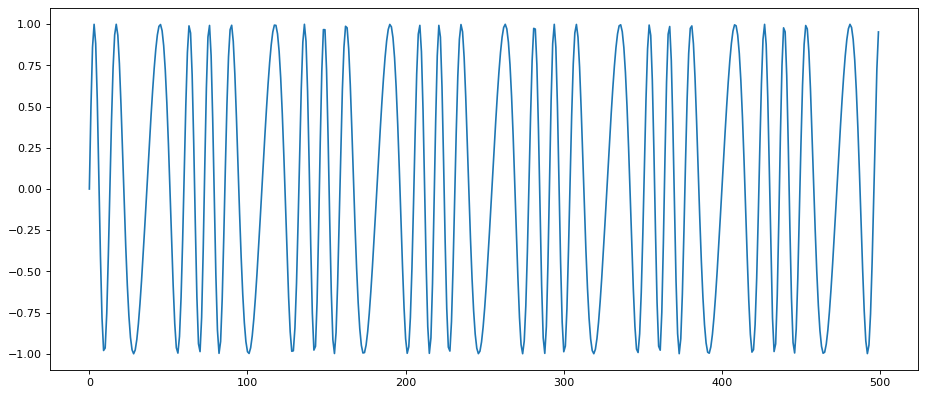

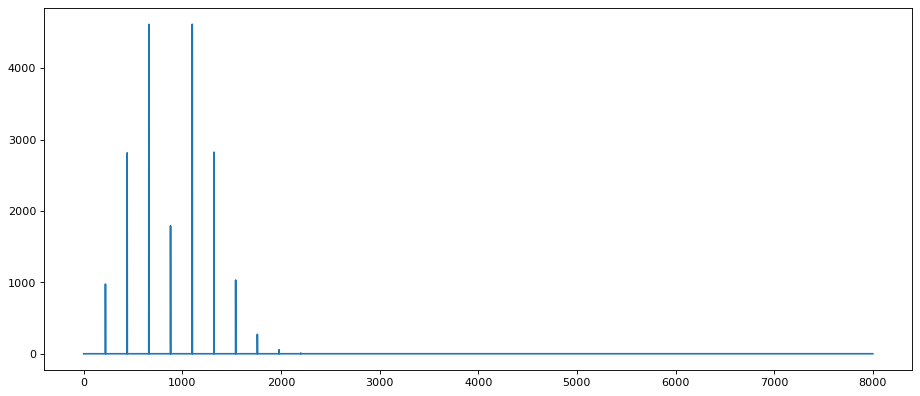

In [2]:
# FM synthesis

# Sampling rate
fs = 16000  

# Carrier frequency
fc = 880

# Modulation frequency
fmod = 220

# Modulation index
I = 2

# number of samples in signal
duration = 1
samples = duration*fs
amplitude = 1

t = np.linspace(0, duration, samples, endpoint=False) 

# The FM modulated signal
y = amplitude * np.sin(2*np.pi*fc*t + I*np.sin(2*np.pi*fmod*t))

# plot signal
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(y[:500])


# compute DFT
dft = fft(y)
freq = np.linspace(0, fs/2, len(y)//2)
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(freq, abs(dft[:len(dft)//2]))

## Problem 2

Text(0.5, 0, 'time [s]')

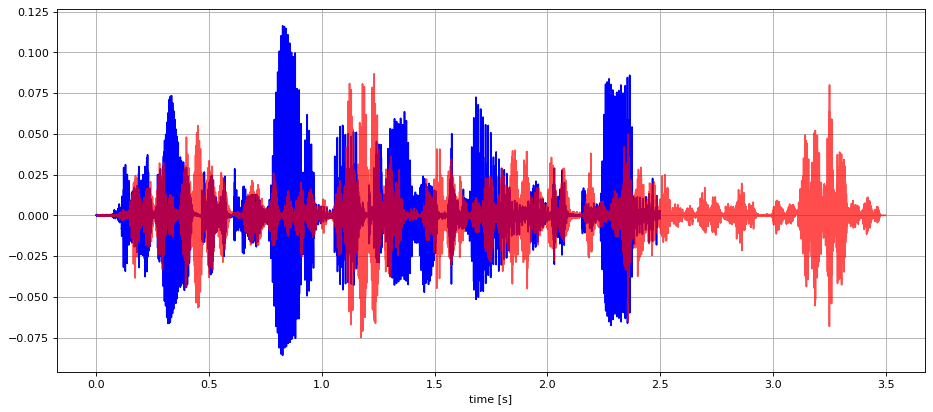

In [3]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  



def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi


R = 1.4 #winHopSyn / winHopAn;
audioIn, fs=lb.load('audio.wav', sr=None) 
#audioIn = np.ones(len(audioIn))
audioOut = np.zeros(int(len(audioIn)*R))
wLen = int(0.032*fs)
winAn = np.sqrt(hann(wLen, sym=False));
winSyn =winAn;

#
winHopAn = int(0.008*fs);
winHopSyn = round(winHopAn*R)

#winHopSyn = int(0.008*fs)
#winHopAn = round(winHopSyn/R)

phi0 = np.zeros(wLen)
psi = np.zeros(wLen)
inInd = 0; outInd = 0;

cnt=0
while inInd< len(audioIn)-wLen:
    # selct the frame and multiply with window function
    frame = audioIn[inInd:inInd+wLen]* winAn

    # compute DFT
    f = fft(fftshift(frame))  
    #f = fft(frame)

    # phase processing in spectral domain
    #delta_phi= omega + princarg(np.angle(f)-phi0-omega)
    delta_phi = delta_phi_(np.angle(f), phi0, winHopAn, wLen) 
    psi = princarg(psi+delta_phi*R)

    # save  phase  for the next iteration
    phi0 = np.angle(f) 

    # Recover the complex FFT back
    ft = (abs(f)* np.exp(1j*psi)) 

    # inverse DFT and windowing
    #frame = np.real(ifft(ft))*winSyn;
    frame = fftshift(np.real(ifft(ft)))*winSyn

    # Ovelap add
    audioOut[outInd:outInd+wLen] =  audioOut[outInd:outInd+wLen] + frame;

    # frame advance
    inInd = inInd + winHopAn;
    outInd = outInd + winHopSyn;
    cnt=cnt+1

plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,len(audioIn) / fs,len(audioIn)),audioIn, 'b')
plt.plot(np.linspace(0,len(audioOut) / fs,len(audioOut)),audioOut, 'r', alpha=0.7)
plt.grid()
plt.xlabel('time [s]')

In [10]:
sd.play(audioIn, fs)

In [11]:
sd.play(audioOut, fs)

## Bonus problem

In [12]:
def resample(signal,pitchRatio):
    output_Length = int((len(signal))/pitchRatio)
    output = np.zeros(output_Length)
    for i in range(output_Length):
        x = float(i*pitchRatio)
        ix = int(np.floor(x))
        dx = x - ix
        output[i] = signal[ix]*(1.0 - dx) + signal[ix+1]*dx
    return output

In [13]:
pitchshift = resample(audioOut,1.4)

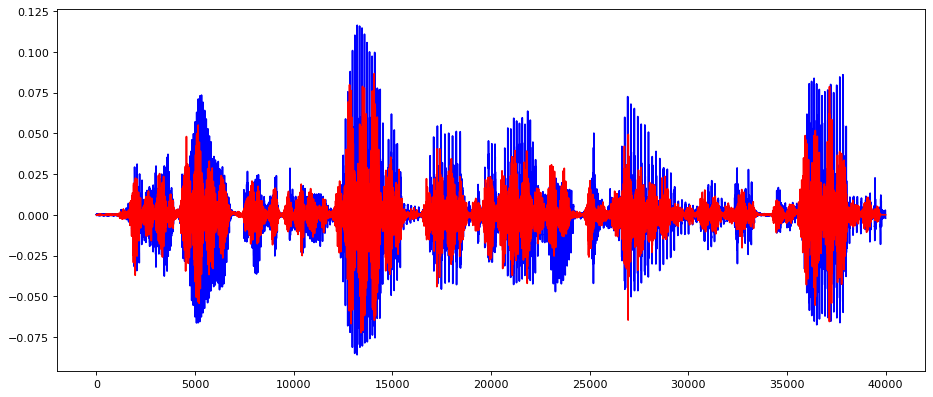

In [14]:
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(audioIn, 'b')
plt.plot(pitchshift, 'r')

In [15]:
sd.play(pitchshift, fs)